<img src="escudo_utfsm.gif" style="float:right;height:100px">
<img src="IsotipoDIisocolor.png" style="float:left;height:100px">
<center>
    <h1> INF564 Diseño avanzado de algoritmos</h1>
    <h2> Tarea N°1 </h2>
    <h2> 24 de mayo del 2019</h2>
    <h4> Roberto Felipe Fuentes Zenteno - 201173037-2 - roberto.fuentes@alumnos.usm.cl</h4>
</center>
<p>
</p>

## Lectura de archivos para posiciones de autos

In [884]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import ipywidgets as widgets
from numpy.random import randint
from numpy.random import seed
from numpy.random import choice
import networkx as nx

In [885]:
def read_pos_cars(file_string):
    x_pos, y_pos = [],[]
    f = open(file_string, "r")
    file = f.readlines()
    for i in range(len(file)):
        x,y = file[i].split(" ")
        x_pos.append(int(x))
        y_pos.append(int(y))
    x_pos = np.array(x_pos)
    y_pos = np.array(y_pos)
    return np.hstack((x_pos.reshape((len(x_pos),1)) , y_pos.reshape((len(y_pos),1))))

## Lectura de archivos para _request_

In [886]:
def read_request(file_string):
    x_pos_i, y_pos_i, x_pos_f, y_pos_f, inst = [],[],[],[],[]
    f = open(file_string, "r")
    file = f.readlines()
    for i in range(len(file)):
        origen, destino, instante = file[i].split(" - ")
        x_i, y_i = origen.split(" ")
        x_f, y_f = destino.split(" ")
        x_pos_i.append(int(x_i))
        y_pos_i.append(int(y_i))
        x_pos_f.append(int(x_f))
        y_pos_f.append(int(y_f))
        inst.append(int(instante))
    x_pos_i = np.array(x_pos_i)
    y_pos_i = np.array(y_pos_i)
    x_pos_f = np.array(x_pos_f)
    y_pos_f = np.array(y_pos_f)
    inst = np.array(inst)
    return np.hstack((x_pos_i.reshape((len(x_pos_i),1)) , y_pos_i.reshape((len(y_pos_i),1)), 
                           x_pos_f.reshape((len(x_pos_f),1)) , y_pos_f.reshape((len(y_pos_f),1)),
                           inst.reshape((len(inst),1))))

## Algoritmo greedy

In [900]:
def alg_greedy(pos_cars, request, time): 
    cost = np.zeros(time)
    busy_cars = np.array([])
    for i in range(time):
        if(len(busy_cars) != 0):
            cost[i] += len(busy_cars)
            cost_remain = np.where(busy_cars[:,2] > 0)[0]
            busy_cars[cost_remain,2] -= 1
            zero_elem = np.where(busy_cars[:,2] == 0)[0]
            for j in zero_elem:
                pos_cars = np.vstack((pos_cars, busy_cars[j,:2]))
            busy_cars = np.delete(busy_cars, zero_elem, axis=0) 
        list_request = np.where(request[:,4] == i)[0]
        if(len(list_request) != 0):
            for j in request[list_request]:
                if(len(pos_cars) > 0):
                    matrix_distant = cdist(np.array([j[:2]]), pos_cars[:,:2], metric='cityblock')
                    index_matrix_distant = np.argmin(matrix_distant,axis=1)[0]
                    element_matrix_distant = np.min(matrix_distant,axis=1)[0]
                    distant_i_f = cdist(np.array([j[:2]]), np.array([j[2:4]]), metric='cityblock')
                    if(len(busy_cars) == 0):
                        busy_cars = np.hstack((busy_cars, np.array([j[2],j[3], (element_matrix_distant + distant_i_f)]))).reshape(1,3)
                    else:
                        busy_cars = np.vstack((busy_cars, np.array([j[2],j[3], (element_matrix_distant + distant_i_f)])))  
                    pos_cars = np.delete(pos_cars, (index_matrix_distant), axis=0)
                else:
                    j[4] += 1
        #if( i > 0):
        #    cost[i] += cost[i-1]
    return cost

## Algoritmo randomizado

In [901]:
def alg_random(pos_cars, request, time, s): 
    seed(s)
    cost = np.zeros(time)
    busy_cars = np.array([])
    for i in range(time):
        if(len(busy_cars) != 0):
            cost[i] += len(busy_cars)
            cost_remain = np.where(busy_cars[:,2] > 0)[0]
            busy_cars[cost_remain,2] -= 1
            zero_elem = np.where(busy_cars[:,2] == 0)[0]
            for j in zero_elem:
                pos_cars = np.vstack((pos_cars, busy_cars[j,:2]))
            busy_cars = np.delete(busy_cars, zero_elem, axis=0) 
        list_request = np.where(request[:,4] == i)[0]
        if(len(list_request) > 0):
            if(len(pos_cars) > 0):
                if(len(pos_cars) < len(list_request)):
                    request[list_request][len(pos_cars):,4] += 1
                    list_request = list_request[:len(pos_cars)]
                random_index_car = choice(len(pos_cars), len(list_request), replace=False)
                random_car = pos_cars[random_index_car]
                random_element_distant = np.sum(abs(random_car-request[list_request][:,:2]), axis = 1)
                distant_i_f = np.sum(abs(request[list_request][:,:2]-request[list_request][:,2:4]), axis = 1)
                total_distant = (distant_i_f + random_element_distant).reshape(len(distant_i_f), 1)
                if(len(busy_cars) == 0):
                    busy_cars = np.hstack((request[list_request][:,2:4], total_distant))
                else:
                    busy_cars = np.vstack((busy_cars, np.hstack((request[list_request][:,2:4], total_distant))))  
                pos_cars = np.delete(pos_cars, (random_index_car), axis=0)
            else:
                request[list_request][:,4] += 1
        #if(i > 0):
        #    cost[i] += cost[i-1]
    return cost

## Algoritmo Harmonic

In [902]:
def alg_harmonic(pos_cars, request, time, s): 
    seed(s)
    cost = np.zeros(time)
    busy_cars = np.array([])
    for i in range(time):
        if(len(busy_cars) != 0):
            cost[i] += len(busy_cars)
            cost_remain = np.where(busy_cars[:,2] > 0)[0]
            busy_cars[cost_remain,2] -= 1
            zero_elem = np.where(busy_cars[:,2] == 0)[0]
            for j in zero_elem:
                pos_cars = np.vstack((pos_cars, busy_cars[j,:2]))
            busy_cars = np.delete(busy_cars, zero_elem, axis=0) 
        list_request = np.where(request[:,4] == i)[0]
        if(len(list_request) > 0):
            if(len(pos_cars) > 0):
                if(len(pos_cars) < len(list_request)):
                    request[list_request][len(pos_cars):,4] += 1
                    list_request = list_request[:len(pos_cars)]
                dM = cdist(pos_cars, request[list_request][:,:2], metric='cityblock')
                dM[dM == 0] = 1
                weights = 1/dM / (sum(1/dM))
                weights = weights.T
                random_index_car = []
                for j in weights:
                    rand = choice(len(pos_cars), 1, p=j)
                    while(rand in random_index_car):
                        rand = choice(len(pos_cars), 1, p=j)
                    random_index_car.append(rand[0])
                random_index_car = np.array(random_index_car)
                random_car = pos_cars[random_index_car]
                random_element_distant = np.sum(abs(random_car-request[list_request][:,:2]), axis = 1)
                distant_i_f = np.sum(abs(request[list_request][:,:2]-request[list_request][:,2:4]), axis = 1)
                total_distant = (distant_i_f + random_element_distant).reshape(len(distant_i_f), 1)
                if(len(busy_cars) == 0):
                    busy_cars = np.hstack((request[list_request][:,2:4], total_distant))
                else:
                    busy_cars = np.vstack((busy_cars, np.hstack((request[list_request][:,2:4], total_distant))))  
                pos_cars = np.delete(pos_cars, (random_index_car), axis=0)
            else:
                request[list_request][:,4] += 1
        #if(i > 0):
        #    cost[i] += cost[i-1]
    return cost

## Comparación de los 3 algoritmos

In [903]:
def set_cost_array(pc_option, r_option, time, s):
    if(pc_option == 1):
        pos_cars = read_pos_cars("manana.dat")
    elif(pc_option == 2):
        pos_cars = read_pos_cars("tarde.dat")
    elif(pc_option == 3):
        pos_cars = read_pos_cars("noche.dat")
    
    if(r_option == 1):
        request = read_request("requests_1.dat")
    elif(r_option == 2):
        request = read_request("requests_2.dat")
    elif(r_option == 3):
        request = read_request("requests_3.dat")
    
    g = alg_greedy(pos_cars, request, time)
    r = alg_random(pos_cars, request, time, s)
    h = alg_harmonic(pos_cars, request, time, s)
    
    return g, r, h

In [904]:
#parameters
s = 4
time = 12000

In [905]:
#request 1
m_r1_g, m_r1_r, m_r1_h  = set_cost_array(1, 1, time, s)
t_r1_g, t_r1_r, t_r1_h  = set_cost_array(2, 1, time, s)
n_r1_g, n_r1_r, n_r1_h  = set_cost_array(3, 1, time, s)

#request 2
m_r2_g, m_r2_r, m_r2_h  = set_cost_array(1, 2, time, s)
t_r2_g, t_r2_r, t_r2_h  = set_cost_array(2, 2, time, s)
n_r2_g, n_r2_r, n_r2_h  = set_cost_array(3, 2, time, s)

#request 3
m_r3_g, m_r3_r, m_r3_h  = set_cost_array(1, 3, time, s)
t_r3_g, t_r3_r, t_r3_h  = set_cost_array(2, 3, time, s)
n_r3_g, n_r3_r, n_r3_h  = set_cost_array(3, 3, time, s)

In [906]:
costs = [m_r1_g, m_r1_r, m_r1_h, t_r1_g, t_r1_r, t_r1_h, n_r1_g, n_r1_r, n_r1_h,
         m_r2_g, m_r2_r, m_r2_h, t_r2_g, t_r2_r, t_r2_h, n_r2_g, n_r2_r, n_r2_h,
         m_r3_g, m_r3_r, m_r3_h, t_r3_g, t_r3_r, t_r3_h, n_r3_g, n_r3_r, n_r3_h]

title = ['Mañana - Request 1', 'Tarde - Request 1', 'Noche - Request 1', 
         'Mañana - Request 2', 'Tarde - Request 2', 'Noche - Request 2',
         'Mañana - Request 3', 'Tarde - Request 3', 'Noche - Request 3']

In [961]:
def plot_costs(costs, title):
    fig = plt.figure(figsize=(20, 18))
    f = 17
    fig.suptitle("Costos en cada instante de tiempo", fontsize=f)
    for i in range(1,10):
        plt.subplot(3, 3, i)
        plt.plot(costs[3*(i-1)], '-o', label='Costo Greedy',ms=1, c = 'r')
        plt.plot(costs[3*(i-1)+1], '-o', label='Costo Random',ms=1, c= 'b')
        plt.plot(costs[3*(i-1)+2], '-o', label='Costo Harmonic',ms=1, c = 'k')
        plt.title(title[i-1], fontsize=f)
        plt.xlabel('Iteración', fontsize=f)
        plt.ylabel('Costo acumulado', fontsize=f)
        plt.legend(loc='best')
        plt.grid(True)
    fig.tight_layout()
    fig.subplots_adjust(top=0.94)
    plt.show()

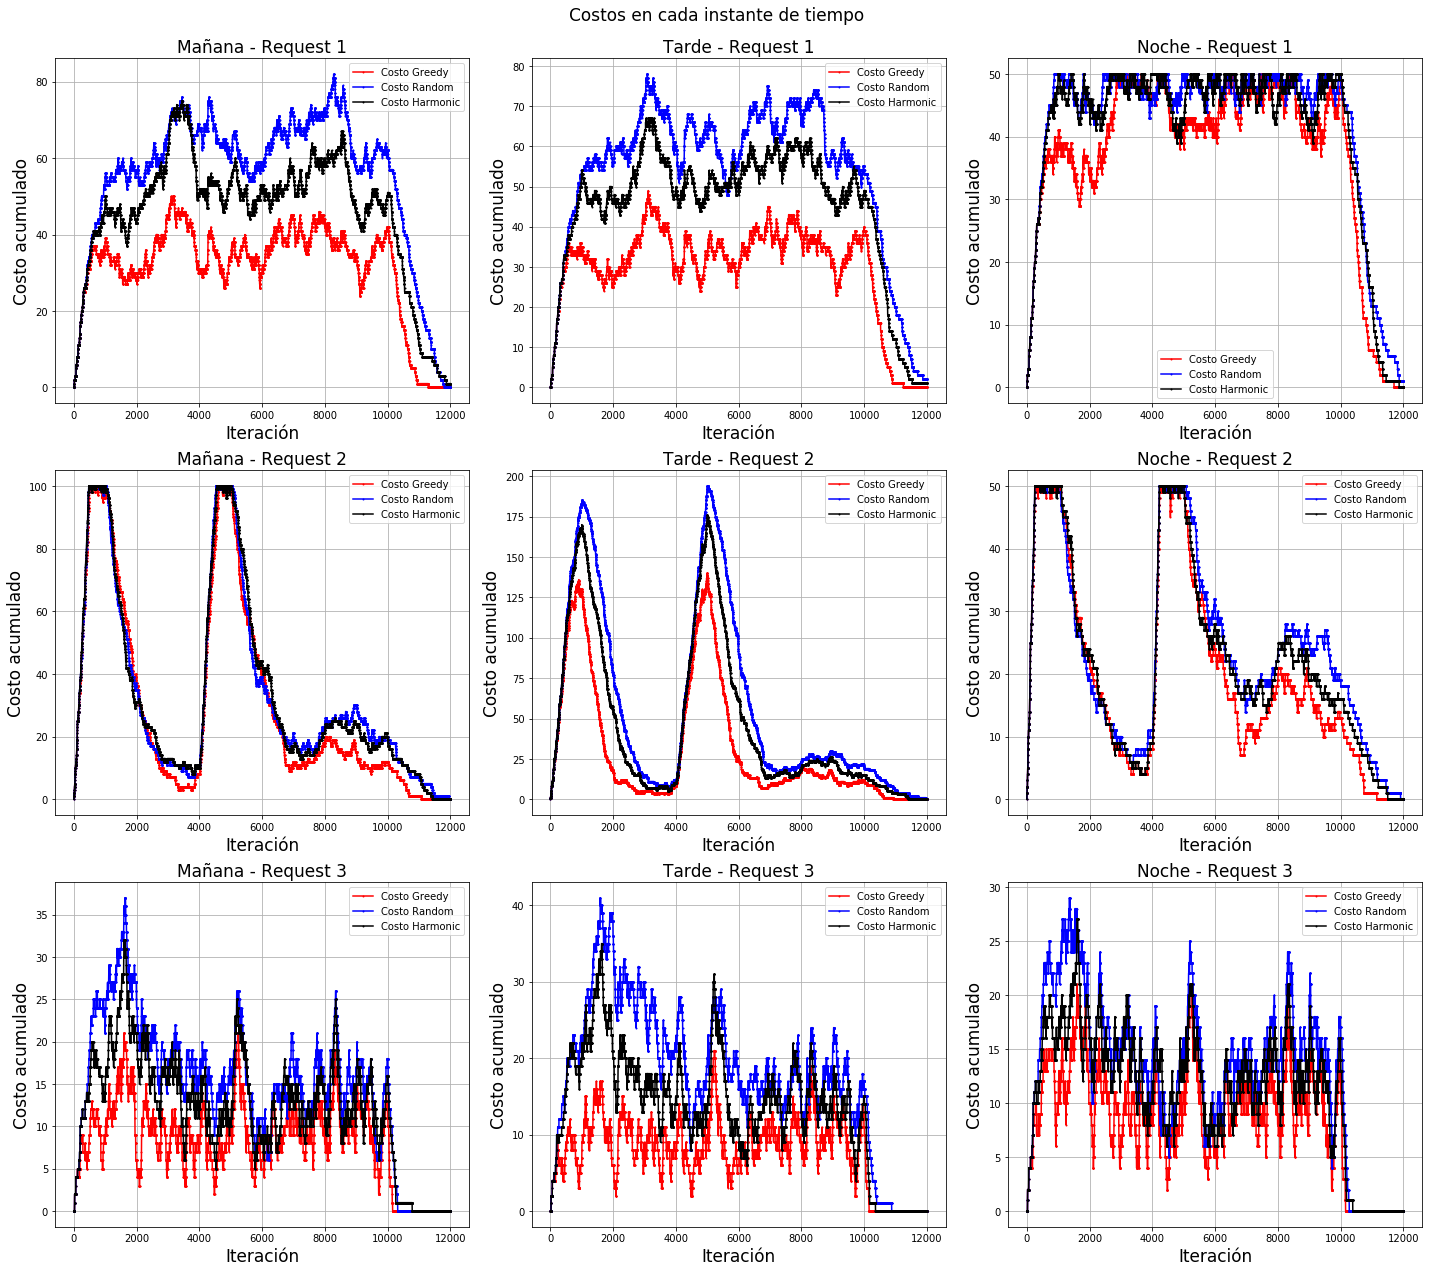

In [962]:
plot_costs(costs, title)

In [963]:
def plot_costs_cumulated(costs, title):
    fig = plt.figure(figsize=(20, 18))
    f = 17
    fig.suptitle("Costos acumlados en cada instante de tiempo", fontsize=f)
    for i in range(1,10):
        plt.subplot(3, 3, i)
        plt.plot(np.cumsum(costs[3*(i-1)]), '-o', label='Costo Greedy',ms=1, c= 'r')
        plt.plot(np.cumsum(costs[3*(i-1)+1]), '-o', label='Costo Random',ms=1, c= 'b')
        plt.plot(np.cumsum(costs[3*(i-1)+2]), '-o', label='Costo Harmonic',ms=1, c = 'k')
        plt.title(title[i-1], fontsize = f)
        plt.xlabel('Iteración', fontsize = f)
        plt.ylabel('Costo acumulado', fontsize = f)
        plt.legend(loc='best')
        plt.grid(True)
    fig.tight_layout()
    fig.subplots_adjust(top=0.94)
    plt.show()

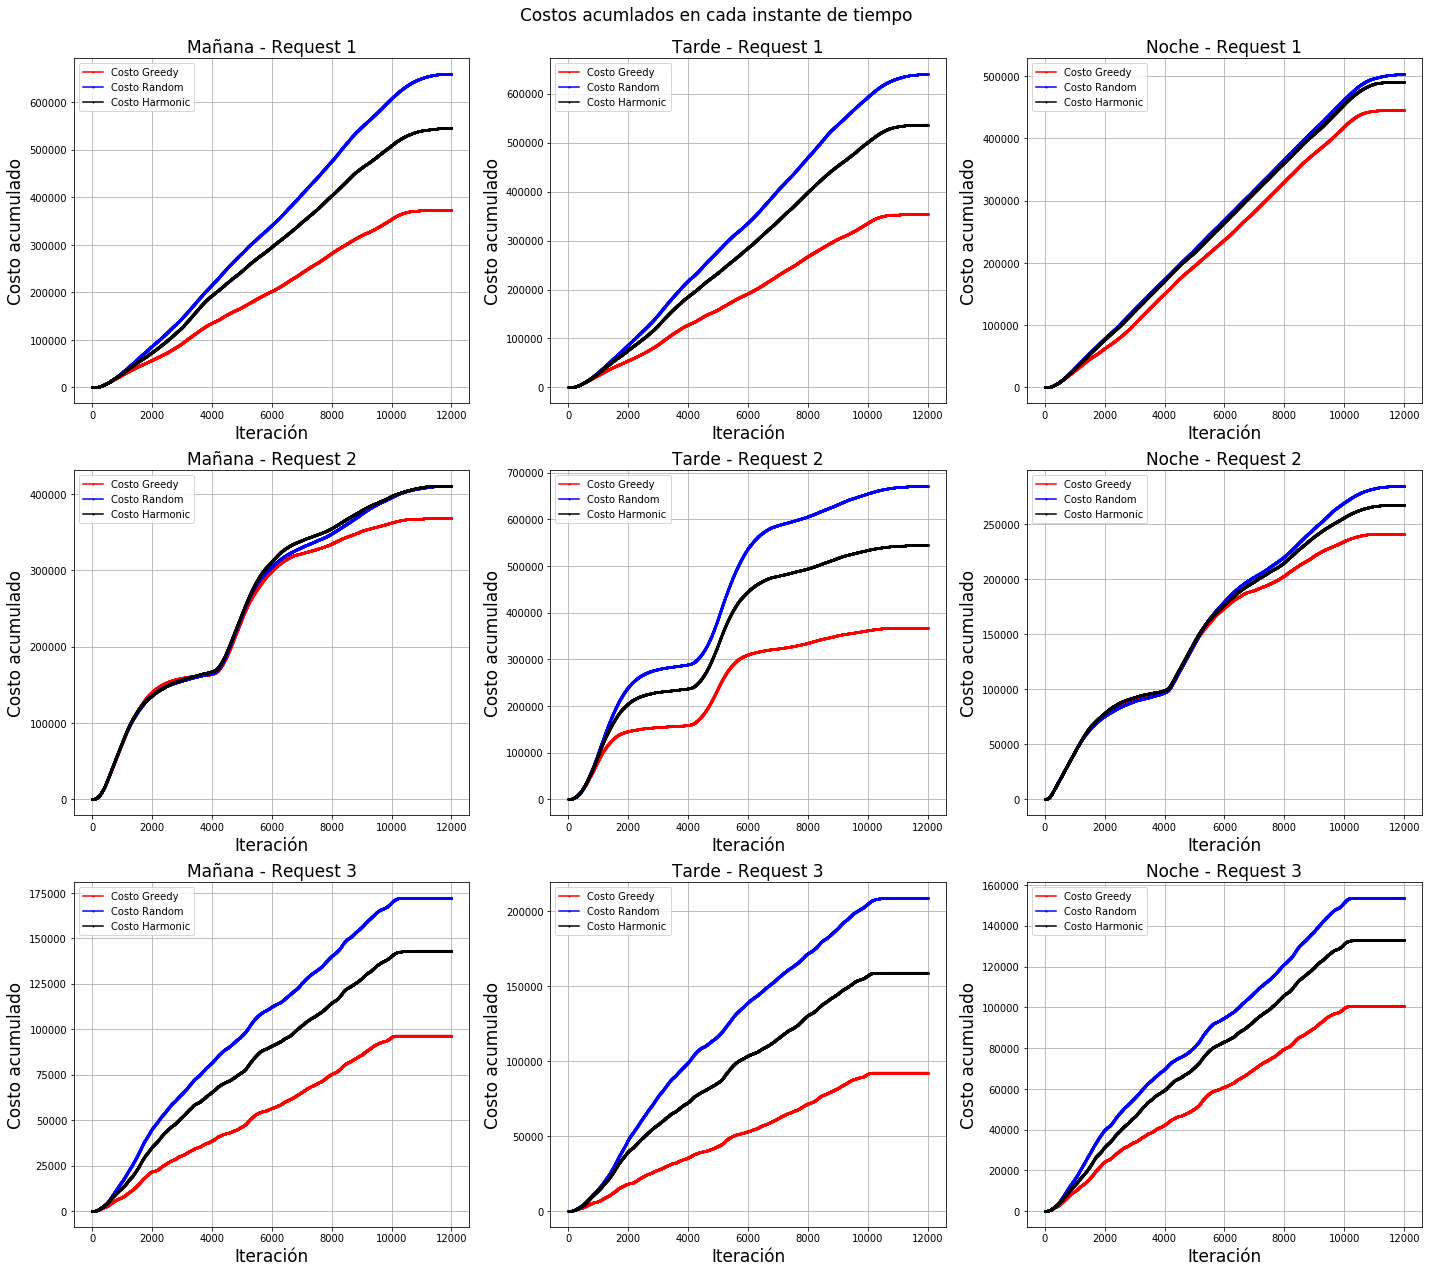

In [964]:
plot_costs_cumulated(costs, title)

In [965]:
def plot_costs_normalized(costs, title):
    fig = plt.figure(figsize=(20, 18))
    f = 17
    fig.suptitle("Costos normalizados en cada instante de tiempo", fontsize=f)
    for i in range(1,10):
        plt.subplot(3, 3, i)
        plt.plot(costs[3*(i-1)]/max(costs[3*(i-1)]), '-o', label='Costo Greedy',ms=1, c='r')
        plt.plot(costs[3*(i-1)+1]/max(costs[3*(i-1)+1]), '-o', label='Costo Random',ms=1, c='b')
        plt.plot(costs[3*(i-1)+2]/max(costs[3*(i-1)+2]), '-o', label='Costo Harmonic',ms=1, c='k')
        plt.title(title[i-1], fontsize = f)
        plt.xlabel('Iteración', fontsize = f)
        plt.ylabel('Costo acumulado', fontsize = f)
        plt.legend(loc='best')
        plt.grid(True)
    fig.tight_layout()
    fig.subplots_adjust(top=0.94)
    plt.show()

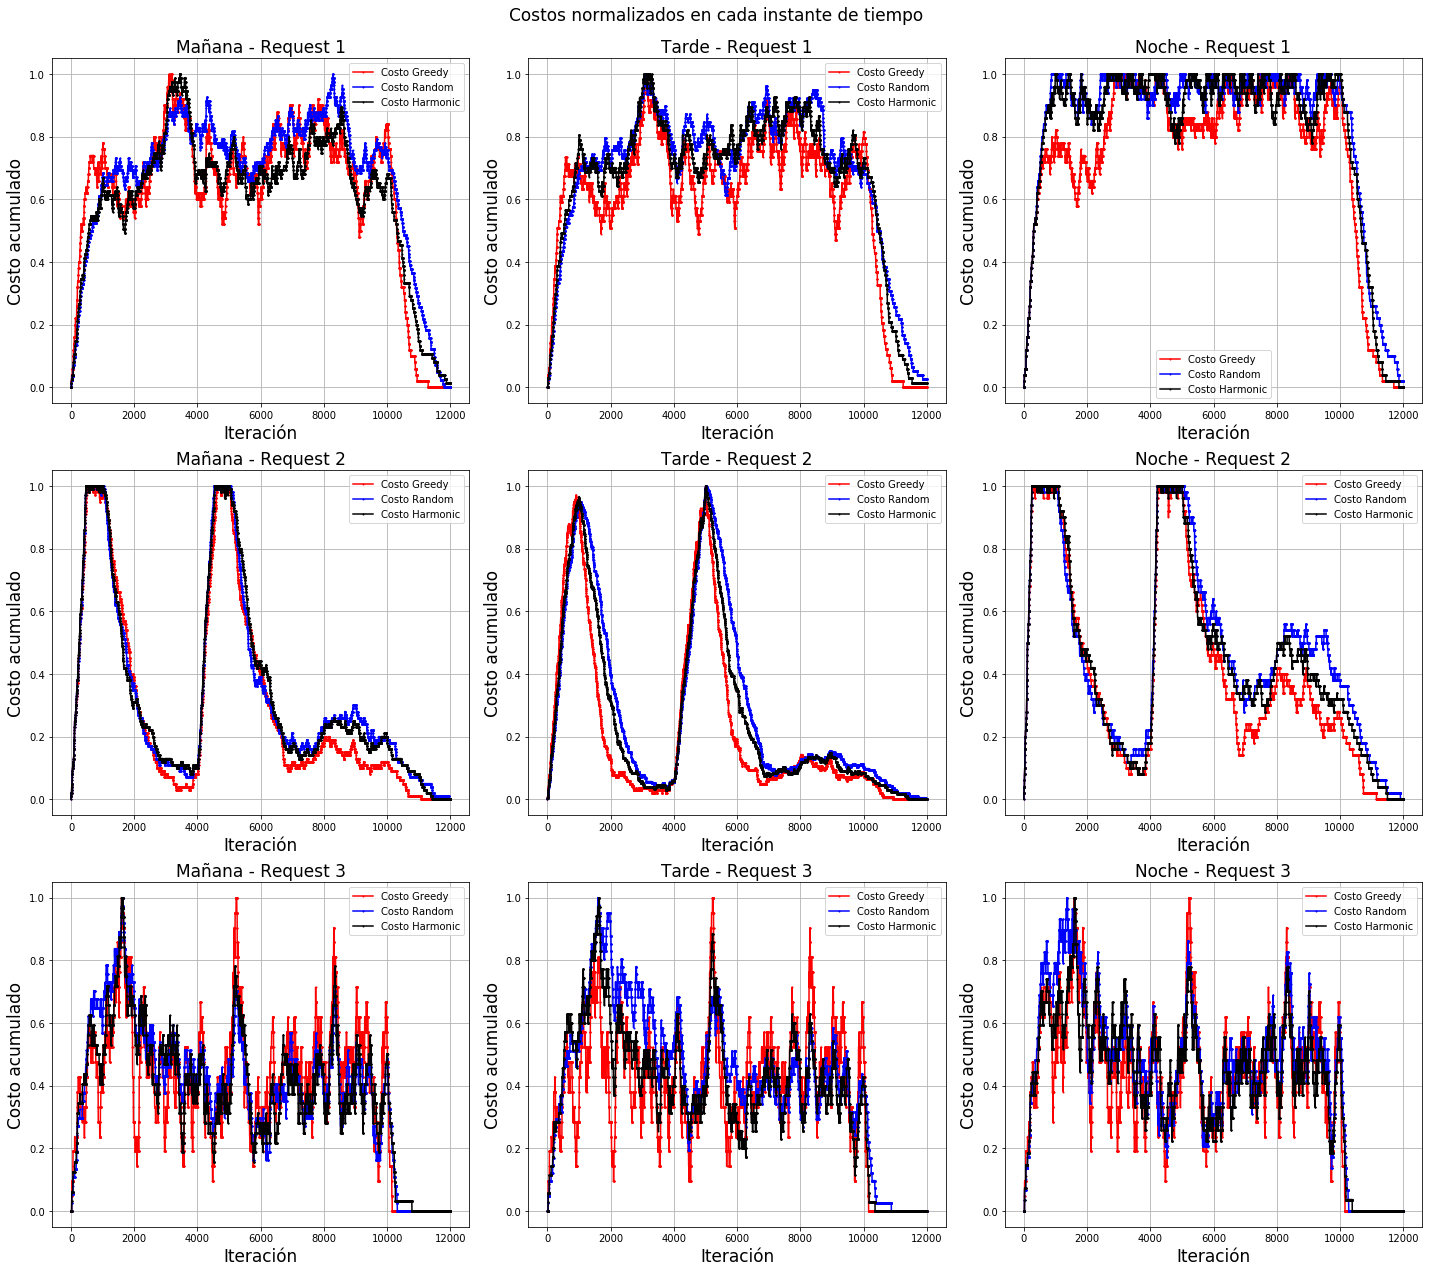

In [966]:
plot_costs_normalized(costs, title)